In [43]:
%matplotlib inline
import os
import sys
import functools
from collections import Counter
import pylab as plt
import numpy as np
import fitsio
from astrometry.util.fits import fits_table, merge_tables
from astrometry.util.util import Tan
from astrometry.util.starutil_numpy import degrees_between
from astrometry.util.plotutils import plothist
from astrometry.libkd.spherematch import match_radec, tree_build_radec, tree_search_radec, tree_open
sys.path.insert(0, 'legacypipe/py')
from legacypipe.gaiacat import GaiaCatalog
from legacypipe.reference import fix_tycho, fix_gaia, merge_gaia_tycho
sys.path.insert(0, 'desiutil/py')
from desiutil.brick import Bricks
#os.environ['GAIA_CAT_DIR'] = '/global/cfs/cdirs/cosmo/work/gaia/chunks-gaia-dr2-astrom-2/'

In [37]:
B = fitsio.read('cosmo/data/legacysurvey/dr9/south/metrics/000/blobs-0009p290.fits.gz')

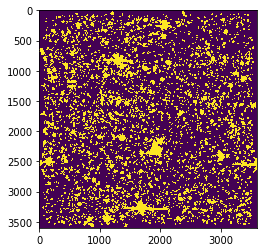

In [41]:
plt.imshow(B > -1)

In [46]:
sbfn = 'skybricks.fits'
if not os.path.exists(sbfn):
    skybricks = Bricks(bricksize=1.0)
    skybricks.to_table().write(sbfn)

In [47]:
SB = fits_table(sbfn)

In [49]:
SB[0]

<tabledata object with 1 rows and 12 columns: brickname=1800m900, brickid=1, brickq=1, brickrow=0, brickcol=0, ra=180.0, dec=-90.0, ra1=0.0, ra2=360.0, dec1=-90.0, dec2=-89.5, area=0.78539317911833>

In [50]:
Bnorth = fits_table('cosmo/data/legacysurvey/dr9/north/survey-bricks-dr9-north.fits.gz')
Bsouth = fits_table('cosmo/data/legacysurvey/dr9/south/survey-bricks-dr9-south.fits.gz')

In [52]:
Bnorth.cut(Bnorth.survey_primary)
Bsouth.cut(Bsouth.survey_primary)

In [55]:
Bsouth.cut(Bsouth.dec > -30)

In [56]:
Bnorth.hemi = np.array(['north']*len(Bnorth))
Bsouth.hemi = np.array(['south']*len(Bsouth))

In [57]:
B = merge_tables([Bnorth, Bsouth])

In [58]:
len(B)

277825

In [60]:
# Rough cut the skybricks to those near bricks.
I,J,d = match_radec(SB.ra, SB.dec, B.ra, B.dec, 1., nearest=True)

In [62]:
SB.cut(I)

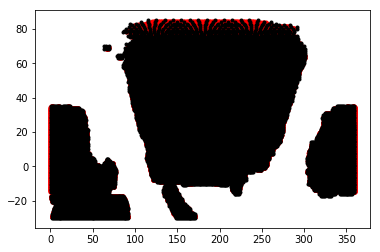

In [64]:
plt.plot(B.ra, B.dec, 'r.')
plt.plot(SB.ra, SB.dec, 'k.');

In [81]:
# HACK -- just for debugging
SB = SB[np.argsort(np.hypot(SB.ra, SB.dec))]

In [100]:
Inear = match_radec(SB.ra, SB.dec, B.ra, B.dec, 0.75, indexlist=True)

In [101]:
Inear[0]

[277687,
 277628,
 83292,
 82898,
 83095,
 83094,
 82897,
 83291,
 83490,
 83693,
 83489,
 83758,
 83543,
 277688,
 83153,
 83350,
 82956,
 83154,
 83351,
 82957,
 83352,
 83155,
 82958,
 83759,
 83544,
 83545]

In [102]:
#sb = SB[0]
#I = np.flatnonzero((B.ra2 > sb.ra1) * (B.ra1 < sb.ra2) * (B.dec2 > sb.dec1) * (B.dec1 < sb.dec2))
#I

In [103]:
from astrometry.util.resample import resample_with_wcs, NoOverlapError

In [118]:
Inear = match_radec(SB.ra, SB.dec, B.ra, B.dec, 1., indexlist=True)

# 3600 + 1% margin on each side
w,h = 3672,3672
binning = 4
# pixscale
cd = 1./3600.

skyblobs = np.zeros((fullh, fullw), bool)
subcount = np.zeros((h,w), np.uint8)

for isb,sb in enumerate(SB):
    print('Skyblob', sb.brickname)
    fullw,fullh = w*binning, h*binning
    fullcd = cd/binning
    skywcs = Tan(sb.ra, sb.dec, (fullw+1)/2., (fullh+1)/2., -fullcd, 0., 0., fullcd, float(fullw), float(fullh))

    skyblobs[:,:] = False

    #skywcs = Tan(sb.ra, sb.dec, (w+1)/2., (h+1)/2., -cd, 0., 0., cd, float(w), float(h))
    # indices of bricks near this skybrick.
    I = np.array(Inear[isb])
    # cut to bricks actually inside the skybrick
    I = I[((B.ra2[I] > sb.ra1) * (B.ra1[I] < sb.ra2) * (B.dec2[I] > sb.dec1) * (B.dec1[I] < sb.dec2))]
    for i in I:
        brickname = B.brickname[i]
        print('Blob', brickname)
        fn = 'cosmo/data/legacysurvey/dr9/%s/metrics/%s/blobs-%s.fits.gz' % (B.hemi[i], brickname[:3], brickname)
        blobs,hdr = fitsio.read(fn, header=True)
        wcs = Tan(hdr)
        #print(wcs)
        blobs = (blobs > -1)
        try:
            Yo,Xo,Yi,Xi,_ = resample_with_wcs(skywcs, wcs)
        except NoOverlapError:
            continue
        # We could have accumulated the count directly here rather than building the binary mask first
        # except that edge blobs appear in neighboring bricks!
        skyblobs[Yo,Xo] |= blobs[Yi,Xi]

    # bin down, counting how many times 'skyblobs' is set
    subcount[:,:] = 0
    for i in range(binning):
        for j in range(binning):
            subcount += skyblobs[i::binning, j::binning]
    subwcs = Tan(sb.ra, sb.dec, (w+1)/2., (h+1)/2., -cd, 0., 0., cd, float(w), float(h))
    
    hdr = fitsio.FITSHDR()
    subwcs.add_to_header(hdr)
    fitsio.write('skybricks/sky-%s.fits.fz' % sb.brickname, blobcount, header=hdr, clobber=True,
                compress='GZIP', tiledim=(256,256))

Skyblob 0005p000
Blob 0006m005
Blob 0001m005
Blob 0003m005
Blob 0003m002
Blob 0001m002
Blob 0006m002
Blob 0008m005
Blob 0008m002
Blob 0008p000
Blob 0003p000
Blob 0006p000
Blob 0001p000
Blob 0003p002
Blob 0006p002
Blob 0001p002
Blob 0006p005
Blob 0003p005
Blob 0001p005
Blob 0008p002
Blob 0008p005
Skyblob 0005m010
Blob 0006m015
Blob 0008m015
Blob 0001m015
Blob 0001m012
Blob 0003m012
Blob 0003m015
Blob 0006m012
Blob 0008m012
Blob 0006m010
Blob 0001m010
Blob 0003m010
Blob 0008m010
Blob 0006m007
Blob 0001m007
Blob 0003m007
Blob 0006m005
Blob 0001m005
Blob 0003m005
Blob 0008m007
Blob 0008m005
Skyblob 0005p010
Blob 0006p005
Blob 0003p005
Blob 0001p005
Blob 0003p007
Blob 0006p007
Blob 0001p007
Blob 0003p010
Blob 0006p010
Blob 0001p010
Blob 0001p012
Blob 0003p012


KeyboardInterrupt: 

In [123]:
    fitsio.write('skybricks/sky-%s.fits.fz' % sb.brickname, blobcount, header=hdr, clobber=True,
                compress='GZIP', tiledim=(256,256))
    print(sb.brickname)

0005p010


In [108]:
Counter(skyblobs.ravel())

Counter({False: 147668349, True: 59691651})

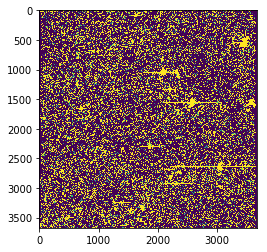

In [115]:
plt.imshow(subcount)

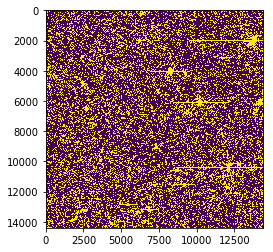

In [109]:
plt.imshow(skyblobs)